<a href="https://colab.research.google.com/github/Aditya2600/Email-Perplexity-and-Prediction-Analysis/blob/main/language_modeling_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import email
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
from os import path
import re
import csv
import tensorflow as tf
from datetime import datetime
import pickle
from IPython.display import display
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import sentence_bleu
from sklearn.utils import shuffle
import nltk
import random
from statistics import *
from nltk import bigrams, trigrams
from collections import Counter, defaultdict
from multiprocessing import Pool
from nltk.corpus import reuters

In [2]:
!gdown 17fzk_EPkPuHeXuCEwkTvsYZ4TdzLFqGy

Downloading...
From (original): https://drive.google.com/uc?id=17fzk_EPkPuHeXuCEwkTvsYZ4TdzLFqGy
From (redirected): https://drive.google.com/uc?id=17fzk_EPkPuHeXuCEwkTvsYZ4TdzLFqGy&confirm=t&uuid=d6f989d3-1056-40ed-82a1-cfdfbfb96e96
To: /content/emails.csv
100% 1.43G/1.43G [00:15<00:00, 93.6MB/s]


In [3]:
df = pd.read_csv("/content/emails.csv")
df = df.sample(frac=0.45, random_state = 42)
df.reset_index(inplace = True, drop = True)
df.head()

,file,message
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...


In [4]:
df['message'][0]

'Message-ID: <21013688.1075844564560.JavaMail.evans@thyme>\nDate: Tue, 29 Aug 2000 01:26:00 -0700 (PDT)\nFrom: sara.shackleton@enron.com\nTo: william.bradford@enron.com\nSubject: Re: Credit Derivatives\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Sara Shackleton\nX-To: William S Bradford\nX-cc: \nX-bcc: \nX-Folder: \\Sara_Shackleton_Dec2000_June2001_1\\Notes Folders\\Sent\nX-Origin: SHACKLETON-S\nX-FileName: sshackle.nsf\n\nBill:  Thanks for the info.   I also spoke with Jeff about how \nEnronCredit.com Ltd. was going to work since Dennis O\'Connell (London lawyer) \nis responsible for that group.  Maybe you will be able to clarify which of \nJeff\'s "positions" will be hedges and which will be backed to EnronCredit.  \nMaybe Rod will be handling most of Jeff\'s credit.  I\'d appreciate an update.  \nSara\n\n\n\n\tWilliam S Bradford\n\t08/29/2000 07:24 AM\n\t\t\n\t\t To: Sara Shackleton/HOU/ECT@ECT\n\t\t cc: Mark Taylor/HOU/EC

In [5]:
def body(messages):
  column = []
  for message in messages:
    e = email.message_from_string(message)
    column.append(e.get_payload())
  return column

df['content'] = body(df['message'])

In [6]:
df.head()

,file,message,content
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...,Bill: Thanks for the info. I also spoke wit...
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...,"Aimee,\nPlease check meter #1591 Lamay gas lif..."
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...,GCCA Crawfish and rip-off raffle & over-priced...
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...,"<<Keoni.zip>> Chris, per your request here ar..."
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...,I'm trying to change the Receipt Meter on deal...


In [7]:
df.content = df.content.str.replace("\n", " ")
df.content = df.content.apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df.content = df.content.str.lower()
df.content = df.content.str.strip()

In [8]:
df.head()

,file,message,content
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...,bill thanks for the info i also spoke with jef...
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...,aimee please check meter 1591 lamay gas lift i...
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...,gcca crawfish and rip off raffle over priced p...
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...,keoni zip chris per your request here are the ...
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...,i m trying to change the receipt meter on deal...


In [9]:
df['body_list'] = df.content.apply(lambda x: x.split())

In [10]:
df.head()

,file,message,content,body_list
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...,bill thanks for the info i also spoke with jef...,"[bill, thanks, for, the, info, i, also, spoke,..."
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...,aimee please check meter 1591 lamay gas lift i...,"[aimee, please, check, meter, 1591, lamay, gas..."
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...,gcca crawfish and rip off raffle over priced p...,"[gcca, crawfish, and, rip, off, raffle, over, ..."
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...,keoni zip chris per your request here are the ...,"[keoni, zip, chris, per, your, request, here, ..."
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...,i m trying to change the receipt meter on deal...,"[i, m, trying, to, change, the, receipt, meter..."


Text(0, 0.5, 'Frequency')

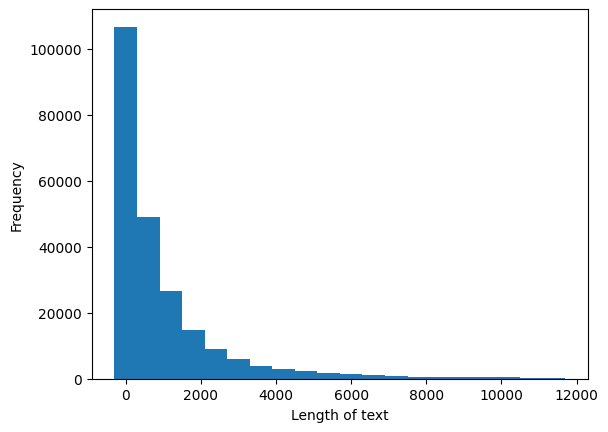

In [11]:
x = list(df['content'].apply(lambda x:len(x)))
plt.hist(x, range=[1, 12000], bins = 20, align = 'left')
plt.rcParams["figure.figsize"] = (10, 4)
plt.xlabel("Length of text")
plt.ylabel("Frequency")

In [12]:
if __name__ == "__main__":
  for i in range(0, 110, 10):
    print("{}th- percentile of len(text) is {}".format(i, np.percentile(x, i)))
    print("="*40)
  x = None
  del(x)
  gc.collect()

0th- percentile of len(text) is 0.0
10th- percentile of len(text) is 100.0
20th- percentile of len(text) is 201.0
30th- percentile of len(text) is 327.0
40th- percentile of len(text) is 485.0
50th- percentile of len(text) is 692.0
60th- percentile of len(text) is 963.0
70th- percentile of len(text) is 1324.0
80th- percentile of len(text) is 1921.0
90th- percentile of len(text) is 3296.0
100th- percentile of len(text) is 1613890.0


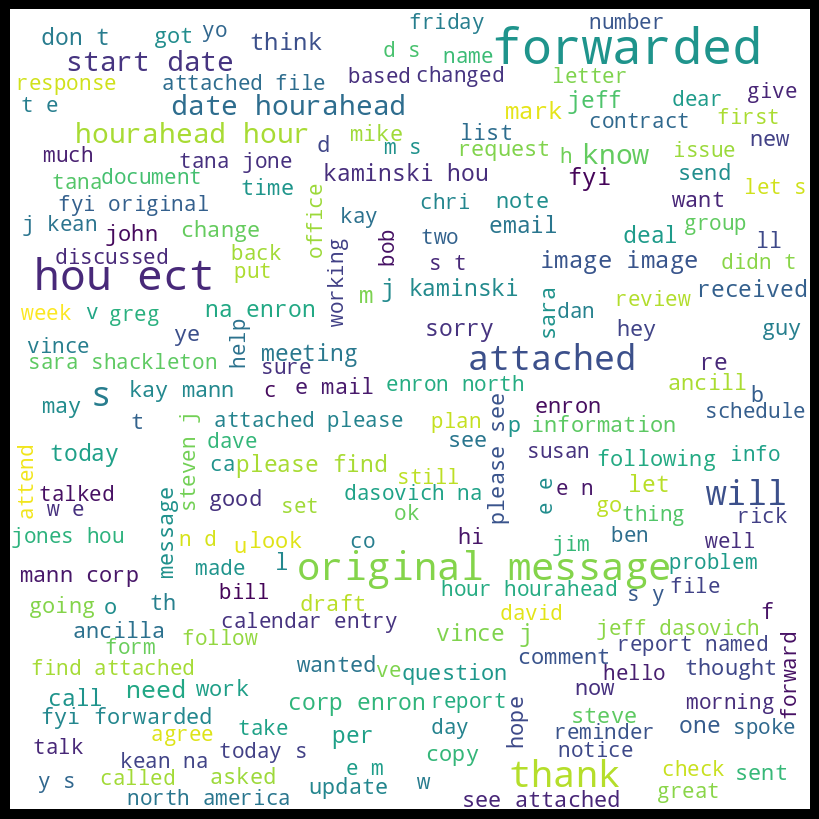

In [13]:
if __name__ == "__main__":
  wordcloud = WordCloud(width = 800, height = 800,
                        background_color = 'white',
                        stopwords = set(STOPWORDS),
                        max_font_size = 50,
                        min_font_size= 10).generate(df['content'].to_string())
  fig = plt.figure(figsize = (8, 8), facecolor = 'k', edgecolor = 'k')
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad = 0)

  plt.show()

In [14]:
def word_count(str):
  counts = dict()
  words = str.split()

  for word in words:
    if word in counts:
      counts[word] += 1
    elif(len(word) > 2):
      counts[word] += 1
  return counts

In [15]:
if __name__ == "__main__":
    most_frequent_words = Counter(" ".join(df["content"]).split()).most_common(10)
    print('\n'.join(map(str, most_frequent_words)))
    most_frequent_words = None
    del(most_frequent_words)
    gc.collect()

('the', 2548843)
('to', 1816173)
('and', 1153394)
('of', 1063568)
('a', 929612)
('enron', 832014)
('in', 785912)
('for', 650932)
('com', 602656)
('on', 562811)


In [16]:
shuffle_df = df.sample(frac=1, random_state = 42)

train_size = int(0.7 * len(df))

train_set = shuffle_df[:train_size]
train_set.reset_index(inplace = True, drop = True)

test_set = shuffle_df[:train_size]
test_set.reset_index(inplace = True, drop = True)


In [17]:
import pandas as pd
df = train_set.copy()
df.head()

,file,message,content,body_list
0,jones-t/all_documents/9893.,Message-ID: <21630252.1075847317308.JavaMail.e...,walter this counterparty is one of the early a...,"[walter, this, counterparty, is, one, of, the,..."
1,steffes-j/sent_items/1367.,Message-ID: <12588977.1075855201936.JavaMail.e...,don t worry appreciate the thought jim origina...,"[don, t, worry, appreciate, the, thought, jim,..."
2,williams-w3/schedule_crawler/493.,Message-ID: <14806696.1075839965425.JavaMail.e...,start date 1 18 02 hourahead hour 1 hourahead ...,"[start, date, 1, 18, 02, hourahead, hour, 1, h..."
3,jones-t/all_documents/4285.,Message-ID: <10250251.1075847017829.JavaMail.e...,attached below is the argentine customer list ...,"[attached, below, is, the, argentine, customer..."
4,shapiro-r/market_structure__seabron_adamson_/3.,Message-ID: <8490280.1075844258735.JavaMail.ev...,jim rick we have revised the draft paper on ma...,"[jim, rick, we, have, revised, the, draft, pap..."


In [18]:
corpus = df['body_list'].to_list()

In [19]:
def build_bigram_model(df):
  bigram_model1 = defaultdict(lambda: defaultdict(lambda: 0))

  for sentence in corpus:
    for w1, w2 in bigrams(sentence, pad_right=True, pad_left=True):
      bigram_model1[w1][w2] += 1

  for w1 in bigram_model1:
    total_count = float(sum(bigram_model1[w1].values()))
    for w2 in bigram_model1[w1]:
      bigram_model1[w1][w2] /= total_count

  return bigram_model1

In [20]:
bigram = build_bigram_model(df)

In [21]:
def get_next_word(model, input_string):
    words = input_string.split()
    if len(words) > 1:
        input_string_ = words[-2:]  # Last two words
        output = model.get(tuple(input_string_), {})
    else:
        output = model.get(words[0], {})

    if not output:  # Check if output is empty
        return f"{input_string} [NO_PREDICTION]"  # Default response

    next_word = max(output, key=output.get)
    return f"{input_string} {next_word}"

In [22]:
get_next_word(bigram, "how")

'how to'

In [23]:
get_next_word(bigram, "what")

'what is'

In [24]:
get_next_word(bigram, "sex")

'sex with'

In [25]:
def build_model(df):
  trigram_model = defaultdict(lambda: defaultdict(lambda: 0))

  for sentence in corpus:
    for w1, w2, w3 in trigrams(sentence, pad_right=True, pad_left=True):
      trigram_model[(w1, w2)][w3] += 1

  for w1_w2 in trigram_model:
    total_count = float(sum(trigram_model[w1_w2].values()))
    for w3 in trigram_model[w1_w2]:
      trigram_model[w1_w2][w3] /= total_count

  return trigram_model

In [26]:
trigram_model = build_model(df)

In [27]:
get_next_word(trigram_model, "fuck you")

'fuck you 19'

In [28]:
get_next_word(trigram_model, "i love")

'i love you'

In [29]:
def complete_sentence(model, input_str, count):
    for i in range(count):
        nxt_word = get_next_word(model, input_str)

        # Stop if no prediction is found
        if "[NO_PREDICTION]" in nxt_word:
            print(f"Step {i}: Prediction not found for '{input_str}'")
            break

        input_str += ' ' + nxt_word.split()[-1]  # Append only the predicted word
        print(f"Step {i}: {input_str}")

In [30]:
complete_sentence(trigram_model, 'can we', 10)

Step 0: can we get
Step 1: can we get the
Step 2: can we get the best
Step 3: can we get the best of
Step 4: can we get the best of luck
Step 5: can we get the best of luck in
Step 6: can we get the best of luck in your
Step 7: can we get the best of luck in your group
Step 8: can we get the best of luck in your group that
Step 9: can we get the best of luck in your group that were


In [33]:
def perplexity(n_gram, input_sentence):
    tokenized_sentence = input_sentence.split()
    pp_w = []
    N = len(tokenized_sentence)

    # For Bigram Model
    if n_gram == 2:
        tokenized_sentence.insert(0, None)  # Add start token
        tokenized_sentence.append(None)    # Add end token
        for i in range(len(tokenized_sentence) - 1):
            w1, w2 = tokenized_sentence[i], tokenized_sentence[i + 1]
            try:
                pp_w.append(1 / (0.0001 + bigram[w1][w2]))
            except KeyError:
                pp_w.append(1 / 0.0001)  # Handle missing bigram

    # For Trigram Model
    elif n_gram == 3:
        tokenized_sentence.insert(0, None)  # Add start token
        tokenized_sentence.insert(0, None)  # Add another start token
        tokenized_sentence.append(None)    # Add end token
        for i in range(len(tokenized_sentence) - 2):
            w1, w2, w3 = tokenized_sentence[i], tokenized_sentence[i + 1], tokenized_sentence[i + 2]
            try:
                pp_w.append(1 / (0.0001 + trigram_model[(w1, w2)][w3]))
            except KeyError:
                pp_w.append(1 / 0.0001)  # Handle missing trigram

    # Calculate Perplexity
    if pp_w and np.prod(pp_w) != 0:
        return round(np.prod(pp_w) ** (1 / N), 2)
    else:
        print("Cannot compute perplexity for the sentence.")
        return None



In [34]:
perplexity_dict = {'content': [], 'bi-gram_score': [], 'tri-gram_score': []}

for i in range(20):
    try:
        body = test_set['content'][i]
        bi_gram = perplexity(2, body)
        tri_gram = perplexity(3, body)
        perplexity_dict['content'].append(body)
        perplexity_dict['bi-gram_score'].append(bi_gram)
        perplexity_dict['tri-gram_score'].append(tri_gram)
    except Exception as e:
        perplexity_dict['content'].append(body)
        perplexity_dict['bi-gram_score'].append(f"Error: {e}")
        perplexity_dict['tri-gram_score'].append(f"Error: {e}")

# Create DataFrame
df2 = pd.DataFrame(perplexity_dict)
df2

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,content,bi-gram_score,tri-gram_score
0,walter this counterparty is one of the early a...,inf,15.22
1,don t worry appreciate the thought jim origina...,124.40,15.45
2,start date 1 18 02 hourahead hour 1 hourahead ...,6.12,1.52
3,attached below is the argentine customer list ...,59.01,12.07
4,jim rick we have revised the draft paper on ma...,inf,9.83
5,last week they made 35 000 total they made 20 ...,inf,inf
6,attached are drafts of two certificates which ...,174.20,9.80
7,way cool i d let reagan follow up ckm from kat...,88.61,14.32
8,dear dr kaminski i would like to thank for the...,164.13,30.34
9,attached are 20 20 purchase and sale agreement...,189.59,25.19
